# Anna Karenina – Character Focus Timeline (Anna vs Levin)

This notebook analyzes **Anna Karenina** (Project Gutenberg text) to track which main character—**Anna** or **Levin**—is in narrative focus per chapter.

We will:

1. Set up paths and imports.
2. Load the Project Gutenberg text and split it into chapters.
3. Define robust regex patterns for character name variants.
4. Count mentions of Anna and Levin per chapter and build summary DataFrames.
5. Create a **Christmas-themed timeline visualization** of the narrative focus.


In [19]:
# CELL 1: Imports and Setup
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import math

# Setup Paths
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_DIR = PROJECT_ROOT / "data"
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

BOOK_FILE = DATA_DIR / "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt"

print(f"Book file exists: {BOOK_FILE.exists()}")

Book file exists: True


## Load Text and Split into Chapters

In this step we:

- Load the raw Project Gutenberg text.
- Strip off the Project Gutenberg boilerplate using the standard `*** START ...` and `*** END ...` markers.
- Use a **case-insensitive** regex to find chapter headings (`CHAPTER I`, `CHAPTER 1`, etc.).
- Extract:
  - `chapters`: the body text for each chapter.
  - `chapter_labels`: the original chapter heading lines.


In [20]:
# CELL 2: Load Text and Split Chapters (FIXED)
if not BOOK_FILE.exists():
    raise FileNotFoundError(f"Could not find Anna Karenina text at: {BOOK_FILE}")

raw_text = BOOK_FILE.read_text(encoding="utf-8", errors="ignore")

# Extract the book body
start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK"
upper = raw_text.upper()
start_idx = upper.find(start_marker)
end_idx = upper.find(end_marker)

if start_idx != -1 and end_idx != -1:
    text = raw_text[start_idx:end_idx]
else:
    text = raw_text

# Regex: Case-Insensitive to catch "Chapter" and "CHAPTER"
chapter_pattern = re.compile(r"^\s*CHAPTER\s+([IVXLCDM0-9]+)\b.*$", re.MULTILINE | re.IGNORECASE)
matches = list(chapter_pattern.finditer(text))

chapters: list[str] = []
chapter_labels: list[str] = []

for i, m in enumerate(matches):
    label = m.group(0).strip()
    start = m.end()
    end = matches[i + 1].start() if i + 1 < len(matches) else len(text)
    chapter_text = text[start:end].strip()
    chapter_labels.append(label)
    chapters.append(chapter_text)

print(f"Detected {len(chapters)} chapter bodies.")

Detected 239 chapter bodies.


## Define Character Name Variants and Counting Function

Here we:

- Enumerate various textual forms of each character’s name (e.g., “Anna Karenina”, “Anna Arkadyevna”, plain “Anna”; “Konstantin Levin”, “Levin”, etc.).
- Compile a single regex per character by OR-ing all variants, case-insensitively.
- Implement `count_mentions(chapter_text)` that returns a dictionary of mention counts for each character in a given chapter.


In [21]:
# CELL 3: Character Regex Setup
character_variants = {
    "Anna": [r"\bAnna Karenina\b", r"\bAnna Arkadyevna\b", r"\bAnna Arkadievna\b", r"\bAnna\b"],
    "Levin": [r"\bKonstantin Dmitrievitch Levin\b", r"\bKonstantin Dmitrievich Levin\b", r"\bKonstantin Levin\b", r"\bLevin\b"],
}

character_regex = {
    name: re.compile("|".join(patterns), flags=re.IGNORECASE)
    for name, patterns in character_variants.items()
}

def count_mentions(chapter_text: str) -> dict[str, int]:
    counts = {}
    for name, pattern in character_regex.items():
        counts[name] = len(pattern.findall(chapter_text))
    return counts

## Build `focus_df`: Simple Per-Chapter Focus (Anna vs Levin)

We now:

- Iterate over all chapter texts and count mentions.
- Decide the **primary focus** for each chapter, based on which character is mentioned more frequently:
  - `"Anna"` – more Anna mentions than Levin.
  - `"Levin"` – more Levin mentions than Anna.
  - `"tie"` – equal counts and both > 0.
  - `"none"` – neither character appears.
- Store the results in a DataFrame `focus_df`, which will be used later for visualization.


In [22]:
# CELL 4: Build Data and Analyze (SAFE VERSION)
rows = []
for idx, (label, chapter_text) in enumerate(zip(chapter_labels, chapters), start=1):
    counts = count_mentions(chapter_text)
    anna = counts.get("Anna", 0)
    levin = counts.get("Levin", 0)
    
    # Determine Primary Focus
    if anna == 0 and levin == 0:
        primary = "none"
    elif anna > levin:
        primary = "Anna"
    elif levin > anna:
        primary = "Levin"
    else:
        primary = "tie"
        
    rows.append({
        "chapter_index": idx,
        "chapter_label": label,
        "anna_count": anna,
        "levin_count": levin,
        "primary": primary
    })

focus_df = pd.DataFrame(rows)

if focus_df.empty:
    print("WARNING: focus_df is empty. Check regex in Cell 2.")
else:
    print(f"Successfully analyzed {len(focus_df)} chapters.")
    display(focus_df.head())

Successfully analyzed 239 chapters.


,chapter_index,chapter_label,anna_count,levin_count,primary
0,1,Chapter 1,0,0,none
1,2,Chapter 2,2,0,Anna
2,3,Chapter 3,0,0,none
3,4,Chapter 4,2,0,Anna
4,5,Chapter 5,1,33,Levin


## Build `timeline_df`: Extended Per-Chapter Metrics

In addition to `focus_df`, we create a slightly richer DataFrame `timeline_df` that includes:

- Raw counts (`anna_count`, `levin_count`)
- Boolean flags: `has_anna`, `has_levin` (did the character appear at all?)
- The same `primary` focus label.

This can be useful for more detailed analyses or alternative visualizations.


In [23]:
# Cell 5 – compute per-chapter focus metrics for Anna vs Levin

import pandas as pd

rows = []

for idx, chapter_text in enumerate(chapters, start=1):
    counts = count_mentions(chapter_text)
    anna = counts.get("Anna", 0)
    levin = counts.get("Levin", 0)

    has_anna = anna > 0
    has_levin = levin > 0

    if not has_anna and not has_levin:
        primary = "none"
    elif anna > levin:
        primary = "Anna"
    elif levin > anna:
        primary = "Levin"
    else:
        primary = "tie"

    rows.append({
        "chapter_index": idx,
        "chapter_label": chapter_labels[idx - 1] if idx - 1 < len(chapter_labels) else f"CHAPTER {idx}",
        "anna_count": anna,
        "levin_count": levin,
        "has_anna": has_anna,
        "has_levin": has_levin,
        "primary": primary,
    })

timeline_df = pd.DataFrame(rows)

print("Columns in timeline_df:", timeline_df.columns.tolist())
timeline_df.head()


Columns in timeline_df: ['chapter_index', 'chapter_label', 'anna_count', 'levin_count', 'has_anna', 'has_levin', 'primary']


,chapter_index,chapter_label,anna_count,levin_count,has_anna,has_levin,primary
0,1,Chapter 1,0,0,False,False,none
1,2,Chapter 2,2,0,True,False,Anna
2,3,Chapter 3,0,0,False,False,none
3,4,Chapter 4,2,0,True,False,Anna
4,5,Chapter 5,1,33,True,True,Levin


## Timeline Visualization

Finally, we visualize the **narrative focus over chapters** using a Christmas palette:

- Map each chapter’s primary focus to a code:
  - `none` → 0 (snowy gray)
  - `tie` → 1 (gold)
  - `Anna` → 2 (red)
  - `Levin` → 3 (green)
- Arrange chapters into 3 horizontal rows for readability.
- Display a heatmap-like timeline where each “cell” is a chapter.
- Add a legend at the bottom explaining the colors.
- Save the figure as `christmas_timeline_presentation.png` in the `results/` directory.


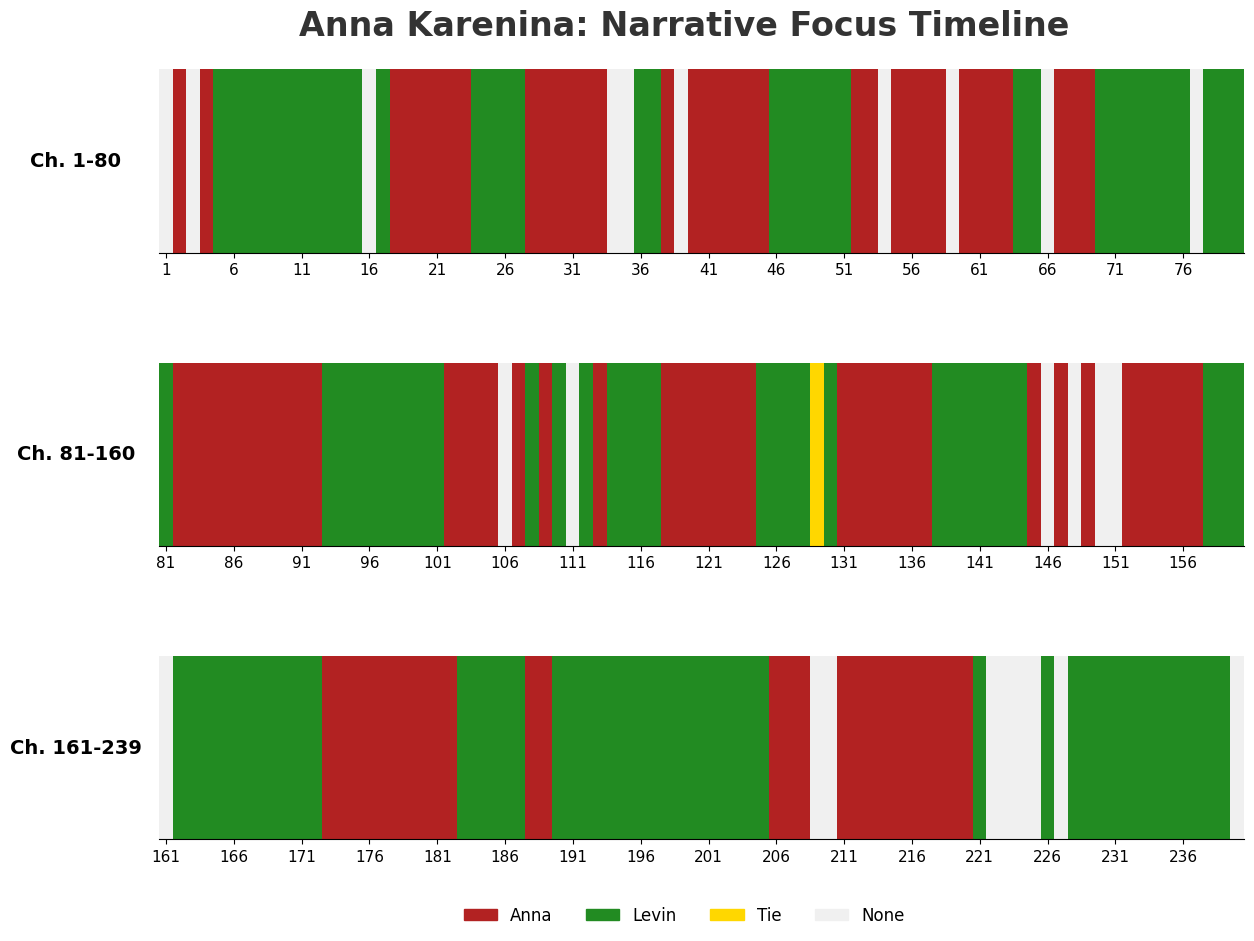

Saved fixed chart to: c:\Users\Andrew\Documents\GitHub\Algorithm-Beyond-The-Text\results\christmas_timeline_presentation.png


In [24]:
# CELL 6 — Christmas-themed fixed layout timeline visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np
import math
import pandas as pd

# Safety check
if "focus_df" not in globals() or focus_df.empty:
    print("Skipping visualization: focus_df is empty or missing.")
else:
    # Make a defensive copy
    df = focus_df.copy()

    # 1. Configuration: Christmas Palette
    color_map = {0: "#F0F0F0", 1: "#FFD700", 2: "#B22222", 3: "#228B22"}
    category_map = {"none": 0, "tie": 1, "Anna": 2, "Levin": 3}

    # Map data: ensure all values are numeric numpy ints
    df["primary_code"] = df["primary"].map(category_map).fillna(0).astype(int)
    all_values = df["primary_code"].to_numpy(dtype=int)  # <-- guarantees numpy array

    # 2. Split into rows
    n_rows = 3
    chapters_per_row = math.ceil(len(all_values) / n_rows)

    # Colormap
    cmap_list = [color_map[i] for i in sorted(color_map.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)

    # 3. Plotting Setup (Manual Layout Control)
    # 3. Plotting Setup (Manual Layout Control)
    fig, axes = plt.subplots(nrows=n_rows, ncols=1, figsize=(14, 10))
    plt.subplots_adjust(hspace=0.6, bottom=0.15, top=0.92)

    fig.suptitle("Anna Karenina: Narrative Focus Timeline", fontsize=24, fontweight='bold', color="#333333")

    for i, ax in enumerate(np.atleast_1d(axes)):
        start_idx = i * chapters_per_row
        end_idx = min((i + 1) * chapters_per_row, len(all_values))
        
        # Calculate theoretical end to keep alignment
        theoretical_end = (i + 1) * chapters_per_row

        # If there is no data for this row, hide the axis
        if start_idx >= len(all_values):
            ax.axis("off")
            continue

        # Get the actual data
        row_slice = all_values[start_idx:end_idx]
        
        # --- THE FIX: PADDING ---
        # If this row is shorter than the max width, pad it with a "hidden" value (e.g. -1)
        # We will mask this later or just let it be white (if 0 is white/snow).
        # Better: use NaN and set background color.
        
        pad_len = chapters_per_row - len(row_slice)
        if pad_len > 0:
            # Pad with 0 (which is "none"/snow in your map) or create a new 'mask' code
            # Here we just pad with 0 so the empty space looks like 'snow' (gray/white)
            padding = np.full(pad_len, 0) 
            row_slice = np.concatenate([row_slice, padding])
            
        row_data = row_slice.reshape(1, -1)

        # Plot Heatmap
        # Note: We now plot the PADDED data so the aspect ratio stays correct
        ax.imshow(row_data, aspect="auto", cmap=custom_cmap, vmin=-0.5, vmax=3.5)

        # Ticks & Labels 
        # Only label the ticks that actually correspond to real chapters
        tick_step = 5
        n_cols = row_data.shape[1]
        local_indices = np.arange(0, n_cols, tick_step)
        
        # Filter indices to stop labeling the empty padded area
        valid_indices = [idx for idx in local_indices if (start_idx + idx) < len(all_values)]
        labels = [(start_idx + 1 + idx) for idx in valid_indices]

        ax.set_xticks(valid_indices)
        ax.set_xticklabels(labels, fontsize=11)
        ax.set_yticks([])
        # Remove borders
        for spine in ["top", "left", "right"]:
            ax.spines[spine].set_visible(False)

        # Row Label
        ax.set_ylabel(f"Ch. {start_idx+1}-{end_idx}", rotation=0, labelpad=60,
                      fontsize=14, fontweight='bold', va="center")

    # 4. Legend (Placed in reserved bottom margin)
    legend_patches = [
        mpatches.Patch(color=color_map[2], label='Anna'),
        mpatches.Patch(color=color_map[3], label='Levin'),
        mpatches.Patch(color=color_map[1], label='Tie'),
        mpatches.Patch(color=color_map[0], label='None')
    ]

    fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.05),
               ncol=4, frameon=False, fontsize=12)

    # Save
    out_file = RESULTS_DIR / "christmas_timeline_presentation.png"
    plt.savefig(out_file, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved fixed chart to: {out_file}")


## Interpretation & Notes — Narrative Focus Timeline

**Figure:** *Anna Karenina — Narrative Focus Timeline*  
(3 rows show chapters 1–80, 81–160, 161–239; colors indicate the chapter-level primary character by mention counts.)

### How to read this plot
- Each colored horizontal block represents a chapter, colored by the **primary** character for that chapter:
  - **Red = Anna** (chapter has more `Anna` mentions than `Levin`)
  - **Green = Levin** (chapter has more `Levin` mentions than `Anna`)
  - **Gold = Tie** (Anna and Levin have the same non-zero mention count)
  - **Light gray (Snow) = None** (neither Anna nor Levin appears)
- The x-axis numbers show chapter indices. The y-axis rows group chapters into three blocks for presentation/readability only — chapters progress left→right across each row.
- The **legend** at the bottom maps colors to characters.

### Important caveats / limitations
- **Name-based counting is a heuristic.** We count literal occurrences of the name tokens (e.g., `Anna`, `Levin`). This may:
  - Miss **pronoun references** (e.g., `she`, `he`) and therefore undercount indirect mentions.
  - Double-count or misattribute in cases of ambiguous forms or quotations.
  - Be influenced by **translation variants** (alternate spellings, use of titles, or omission of a first name). We attempted to include common variants but this is not foolproof.
- **Primary = more mentions, not narrative POV.** A chapter where Anna is `primary` by mentions might still be narrated from another character's mind; mention counts are a simple proxy for focus.
- **Chapter boundaries matter.** We used Gutenberg-derived chapter splits — different editions or chaptering schemes will change exact counts and positions.
- **Short chapters / sparse mentions.** Very short chapters or chapters with small absolute counts can be noisy; consider smoothing (e.g., 3-chapter rolling majority) if you want a less brittle signal.

### Reproducibility & parameters
- **Data source:** `data/Anna_Karenina.txt` (Gutenberg-cleaned).  
- **Segmenting:** chapter-splitting by regex detecting chapter headers (see chapter-splitting cell).  
- **Character list used (exact tokens):** `['Anna', 'Anna Karenina', 'Anna Arkadyevna', 'Levin', 'Konstantin Levin']` (case-insensitive).  
- **Counting function:** `count_mentions(text)` — counts literal token matches; punctuation-insensitive.  
- **Export:** `results/anna_levin_focus_timeline.csv` contains per-chapter counts and the `primary` label.

### Next steps & robustness checks (optional)
- **Include pronoun resolution** (coreference): run a coreference model (spaCy + coref) to capture mentions by pronoun and improve attribution.  
- **Smoothing:** show a rolling-window majority (e.g., 3-chapter) to reduce noise and highlight long arcs.  
- **Combine with POV / direct-speech detection:** cross-check whether `primary` chapters coincide with direct-speech heavy chapters (dialogue ratio) or with sentences assigned to the narrator’s perspective (if you have POV detection).

---